In [221]:
# Importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, LeaveOneOut, learning_curve, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn.datasets import load_digits

In [222]:
# Import Data Into Dataframe and filter
df = pd.read_csv('Target variable & Features (V3).csv')
data = df[df['Threshold method'] == 'yen']
data = df[['Threshold: separation', 'Threshold: border', 'User score']]


In [223]:
# Define x and y
x_var = ['Threshold: separation', 'Threshold: border']
y_var = 'User score'

X = data[x_var]
y = data[y_var]

## Analyzing the features

In [224]:
def create_histplot(data):
    return sns.histplot(data, kde = True)

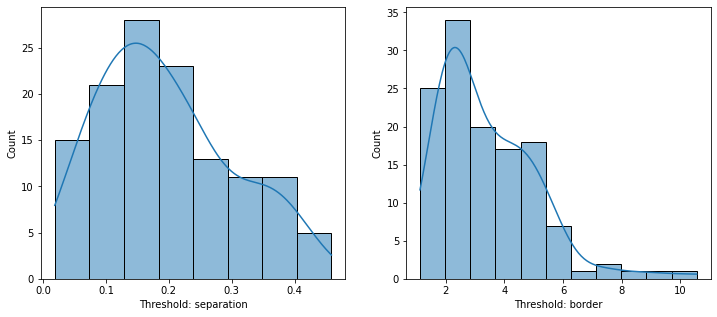

In [225]:
# Analyze data

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
create_histplot(X['Threshold: separation'])

plt.subplot(1,2,2)
create_histplot(X['Threshold: border'])

### Analisis of the Hist plots of the features chosen
Looking at the histograms it is clear that the border atribute doesnt have a normal distribution while separation look to have a more normal distribution. Im going to aply the box-cox transformation to try to normalize the values more. We can also see that there are no obious outlier in the feature set.

### Box-Cox

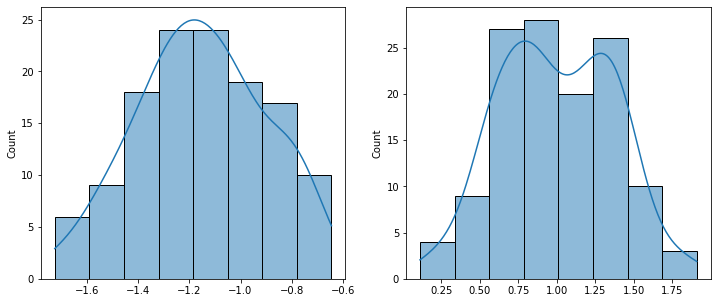

In [226]:
# aply box-cox tranformation on features

fitted_data_separation, fitted_lambda = stats.boxcox(X['Threshold: separation']) 
fitted_data_border, fitted_lambda = stats.boxcox(X['Threshold: border'])

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
create_histplot(fitted_data_separation)

plt.subplot(1,2,2)
create_histplot(fitted_data_border)

X_fitted_dict = {'Threshold: separation': fitted_data_separation,
           'Threshold: border': fitted_data_border}

X_fitted = df.from_dict(X_fitted_dict)

## Learning Curves Loss vs Degree

In [8]:
def fit_poly(degree=1):
    model = make_pipeline(PolynomialFeatures(degree= degree), LinearRegression())
    return model

In [9]:
def plot(x, series, ylabel='loss', xlabel='degree'):
    for label, y in series.items():
        plt.plot(x, y, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
def create_learningcurve(d, degrees=5, label=''):
    
    # Create polynomial models we are going to use
    models = [fit_poly(degree) for degree in range(1, degrees+1)]
    
    train_loss = []
    valid_loss = []
    degrees = []
    degree = 1
    
    for m in models:
        # Using leave one out cross validation
        scoring = cross_validate(m, d, y, scoring='neg_mean_absolute_error', return_train_score=True, cv=d.shape[0])
        degrees.append(degree)
        train_loss.append(scoring['train_score'].mean() * -1)
        valid_loss.append(scoring['test_score'].mean() * -1)
        degree = degree + 1

    # Create learning curve for loss function with root of mean_squared_error
    return degrees, {'train'+ label: train_loss, 'valid' + label: valid_loss}

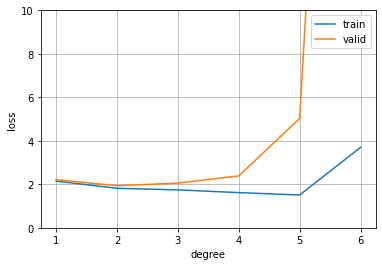

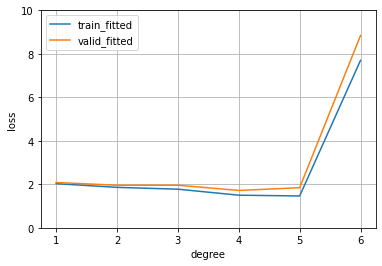

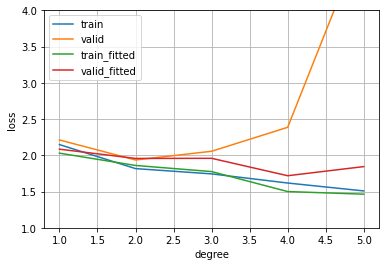

In [11]:
# Polynomial Regression
# By comparing the fitted features to the normal features

n_degrees = 6

# generate learning curve data for normal data
degrees, scores_X = create_learningcurve(X, degrees=n_degrees)

# generate learning curve data for Fitted data
degrees, scores_X_fitted = create_learningcurve(X_fitted, degrees=n_degrees, label='_fitted')


# Visualize the different Learning curves
plt.ylim(0,10)
plot(degrees, scores_X)

plt.ylim(0,10)
plot(degrees, scores_X_fitted)

n_degrees = 5


# generate zoomed learning curve data for normal data
degrees, scores_X = create_learningcurve(X, degrees=n_degrees)


# generate zoomed learning curve data for Fitted data
degrees, scores_X_fitted = create_learningcurve(X_fitted, degrees=n_degrees, label='_fitted')

# Visualize the zoomed learning curves
combined_scores = {}
combined_scores.update(scores_X)
combined_scores.update(scores_X_fitted)
plt.ylim(1,4)
plot(degrees, combined_scores)


### Analysis of the Learning curves Degree vs Loss
When looking at the two curves you can see that the more polynomials you add the more the model is going to overfit. Cant add more training data and when removing features the model gets worse. When comparing the fitted and normal data you can see that the fitted data doesnt overfit as much on the higher polynomials. On the zoomed figure it is visable that the fourth polynomial with the fitted data fits the model best. 

In [227]:
def generate_learning_curve(model, X, y, cv, score, incr):
    data = X.copy()
    data['target_value'] = y
    data_split = np.array_split(data, 1/incr)
    cur_X = pd.DataFrame()
    cur_y = pd.DataFrame()
    total_scores_train = []
    total_scores_test = []

    for d in data_split:
        y_split = d['target_value']
        
        X_split = d.drop(['target_value'], axis=1)
        
        if(cur_X.empty):
            cur_X = X_split
        else:
            cur_X = pd.concat([cur_X, X_split])
            
        if(cur_y.empty):
            cur_y = y_split
        else:
            cur_y = pd.concat([cur_y, y_split])
        
        train_scores = []
        test_scores = []
        for train_index, test_index in cv.split(cur_X):
            
            X_train, X_test = cur_X.loc[(train_index)], cur_X.loc[(test_index)]
            y_train, y_test = cur_y.loc[(train_index)], cur_y.loc[(test_index)]

            model.fit(X_train, y_train)
            
            pred_train = model.predict(X_train)
            pred_test = model.predict(X_test)
            train_scores.append(mean_absolute_error(y_train, pred_train))
            test_scores.append(mean_absolute_error(y_test, pred_test))

            
        train_scores_mean = sum(train_scores) / len(train_scores)
        test_scores_mean = sum(test_scores) / len(test_scores)
        
        total_scores_train.append(train_scores_mean)
        total_scores_test.append(test_scores_mean)
    
    itteration_arr = []
    
    for itt in range(int(1/incr)):
        itteration_arr.append(str(int(100 * round((itt + 1) * incr, 1))) + '%')
    
    plt.grid()
    plt.ylim(0, 5)
    plt.plot(itteration_arr, total_scores_train)
    plt.plot(itteration_arr, total_scores_test)
    plt.xlabel('Percentage of samples used')
    plt.ylabel('Mean Absolute Error')
    plt.title('Learning Curve Polynomial Regression, degree=4')
    
    plt.show()
    print('At training 100% the Mean Absolute Error is ', round(total_scores_test[-1], 3))
        


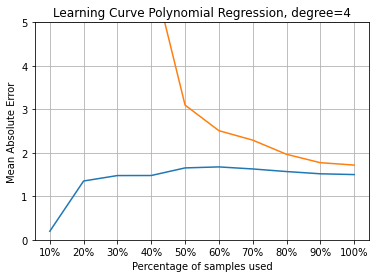

At training 100% the Mean Absolute Error is  1.718


In [228]:
# Create model
model = make_pipeline(PolynomialFeatures(degree= 4), LinearRegression())

# Create splitting itteratable
cv = LeaveOneOut()

generate_learning_curve(model, X_fitted, y, cv, mean_absolute_error, 0.1)

### Analysis of the learning curve Loss vs Samples used
When looking at the training and test set curves you can see that the lines are coming closer together, but there still remaines a big gap between them. Also the loss is high for the training and test set. The gap indicates that the model is overfitting and can be improved by increasing the data samples. On the other end the high loss for training and test indicates that there is a high bias (underfitting). This could be improved by increasing the model complexity but as seen in the analysis of the degree vs loss figure this is not the case. 

Possible improvements:
- more data
- Better samples